# Implementing Linear Regression as a Machine Learning Model
In this notebook, we will revisit linear regression and consider implementing it as a trainable machine learning model.

**Learning Objectives**

By the end of this notebook, you should be able to

1. List some machine learning key terms and identify how they differ from notation in traditional math textbooks.
2. Write a Python class to implement linear regression.
3. Visualize the loss function of a model as a function of the training iterations.

**Import modules**

Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In the previous notebook, we saw how we could fit a linear model to some data using an iterative approach. In this notebook, we are going to continue with this theme, abstracting some of the key ideas into a structure and approach we can use for a wide variety of problems.

## Formulating a Model Framework

To begin, let's reconsider our linear regression model and introduce some new terminology.

In our math classes, we describe the line we are trying to fit to the data as having a slope $w$ (err, perhaps $m$) and intercept $b$. We combine the these constants together in line with the equation

$$
\hat{y} = wx + b
$$

where the "hat" symbol above the $y$ indicates it is a model estimate of some true value $y$. In the world of Machine Learning, we will adopt some new terminology.

### The Forward Model
The first update to our terminology is that we will start by calling $w$ a **weight** and $b$ a **bias**. These *parameters* are utilized by our model to produce a *predicted value*. This part of the line-fitting process is what we'll call the **Forward Model**.

In our previous notebook, we saw that would could write our equations in matrix form as 

$$
\begin{bmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots \\ \hat{y}_N \end{bmatrix} = w \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_N \end{bmatrix} + b\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}\\
$$

or, more succinctly as

$$
\hat{\textbf{y}} = \textbf{X} \cdot \textbf{w}
$$

### Training the Model
Once we have our predicted values, we can compare with our target values to determine our error. We compute these differences using a **Loss Function** (which in math class and our previous notebook we have referred to as a "cost function" or simply an error). For linear regression, our Loss Function is the *Mean Square Error*

$$
L =\frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$

Based on these differences, we can then update our weight and bias to produce predicted values which are closer to our target values. This step is the **Model Training** step and utilizes the idea of gradient descent. In our previous notebook, we computed the gradients of our cost function relative to both the weight and the bias:

$$
\begin{align*}
\frac{\partial L}{\partial b} & = \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i))\\
\frac{\partial L}{\partial w} & = \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i)x_i
\end{align*}
$$

We can simplify this in notation considerably again using vector notation. Let's collect the two partial derivatives into a vector derivative with

$$
\begin{align*}
\frac{\partial L}{\partial \textbf{w}} &= \begin{bmatrix} \frac{\partial L}{\partial b} & \frac{\partial L}{\partial w} \end{bmatrix} \\
&= \frac{-2}{N}  \begin{bmatrix} \sum_{i=1}^N (y_i - \hat{y}_i)) & \sum_{i=1}^N (y_i - \hat{y}_i)x_i \end{bmatrix} \\
&= \frac{-2}{N} \begin{bmatrix} (y_1 - \hat{y}_1) (y_2 - \hat{y}_2) \cdots (y_N - \hat{y}_N) \end{bmatrix} \cdot \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots\\ 1 & x_N \end{bmatrix}\\
&= \frac{-2}{N} (\textbf{y} - \hat{\textbf{y}})^T \cdot \textbf{X}
\end{align*}
$$

Or  more concisely:

$$
\frac{\partial L}{\partial \textbf{w}} = \frac{-2}{N} (\textbf{y} - \hat{\textbf{y}})^T \cdot \textbf{X}
$$

This notation will be particularly advantageous when we code up our solution below.

Here we have taken our simple example and given it a bit of a structure that will allow us to apply it to a large range of applications. This process - the construction of a forward model and the definition of the loss function - is at the heart of many approaches in Machine Learning algorithms.

We can put these steps together into a diagram as follows:

```{image} ../images/Linear_Regression_Schematic.png
:alt: Linear Regression Schematic
:width: 500px
:align: center
```

## Defining a Linear Regression Python Class

Now that we've got some notation out of the way, let's define a Python structure that utilizes our generalized notation. We will do this in the form of a `class` which we use to make objects. Many of the existing Machine Learning packages use this approach, so we will follow with this paradigm. Let's check out out example:

In [2]:
class LinearRegression:
    """
    A python class implementation of a linear regression model.
    """

    def __init__(self, X, learning_rate, n_iterations, random_seed=1):
        """
        Initializes the LinearRegression model and its parameters.
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.random_seed = random_seed
        self.initialize(X)

    def initialize(self, X):
        """
        Initializes the weight vector with small random values.
        """
        np.random.seed(self.random_seed)
        self.w = np.random.normal(loc=0.0, scale=0.01, size=np.shape(X)[1])
    
    def forward(self, X):
        """
        Computes the predicted output using the current weights.
        """
        y_hat = np.dot(X, self.w)
        return y_hat

    def loss(self, y, y_hat):
        """
        Computes the mean sum of squared errors loss.
        """
        return (1/np.size(y))*np.sum((y - y_hat) ** 2)

    def loss_gradient(self, X, y, y_hat):
        """
        Computes the gradient of the loss with respect to weights.
        """
        N = np.size(y)
        gradient = (-2 / N) * np.dot((y-y_hat).T,X)
        return gradient

    def fit(self, X, y):
        """
        Trains the linear regression model using gradient descent.
        """
        self.losses = []
        for iteration in range(self.n_iterations):
            y_hat = self.forward(X)
            gradient = self.loss_gradient(X, y, y_hat)
            self.w -= self.learning_rate * gradient
            self.losses.append(self.loss(y, y_hat))

### Using a Model Object

Just as in our first notebook, let's take a look at some data. Here, we'll use the same dataset for carbon dioxide concentration as we did previously:

In [3]:
# read in the dataset as shown in the previous notebook
df = pd.read_csv('../data/monthly_in_situ_co2_mlo.csv', skiprows=64)
df = df[df.iloc[:, 4] >0]

# subset to a given time range
df_subset = df[(df.iloc[:,3]>=2010) & (df.iloc[:,3]<=2020)]

# redefine x and y
x = np.array(df_subset.iloc[:,3])
y = np.array(df_subset.iloc[:,4])

# remove the first value of y
x = x-2010
y = y-y[0]

As a reminder, these points were historically collected using individual measurements! The following picture shows Charles Keeling taking one such measurement:

```{image} ../images/Keeling_CO2_Measurement.jpg
:alt: Charles Keeling taking a CO2 measurement
:width: 500px
:align: center
```

Photo Credit: Keeling Family, [Scripps Institute of Oceanography](https://scrippsco2.ucsd.edu/history_legacy/charles_david_keeling_biography.html)

Using the notation defined above, let's make our **X** matrix using our data:

In [4]:
X = np.column_stack([np.ones((np.size(x),)), x])

Next, we can drop this into our model:

In [5]:
model = LinearRegression(X, learning_rate=0.01, n_iterations=50)

Now, using the `forward` method of our class, we can test out how our model is doing:

In [6]:
y_predict = model.forward(X)

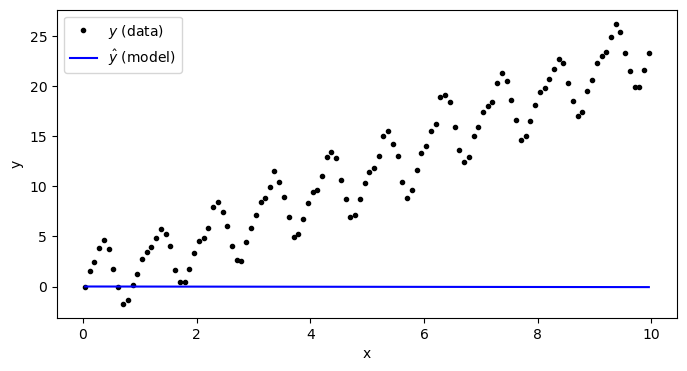

In [7]:
plt.figure(figsize=(8,4))
plt.plot(x,y,'k.',label='$y$ (data)')
plt.plot(x,y_predict,'b-',label='$\\hat{y}$ (model)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=2)
plt.show()

As we can see, our model isn't good at all - and that's because we haven't "trained" it on our data yet. Let's check the weight and the bias of our model:

In [8]:
print('Bias:',model.w[0])
print('Weight:',model.w[1])

Bias: 0.01624345363663242
Weight: -0.006117564136500754


These values were simply generated with the random value generator in the `initialize` function. We use random values for initializing the bias and weight rather than 0 so that the gradients can be computed.

Let's go ahead and train our model.

### Training a Model Object

The model can be trained with the `fit` function implemented inthe class.

In [9]:
model.fit(X,y)

After calling the fit function, we see that the bias and the weight have changes:

In [10]:
print('Bias:',model.w[0])
print('Weight:',model.w[1])

Bias: 0.25423830193795494
Weight: 2.308690415279125


Let's see how our model looks now:

In [11]:
y_predict = model.forward(X)

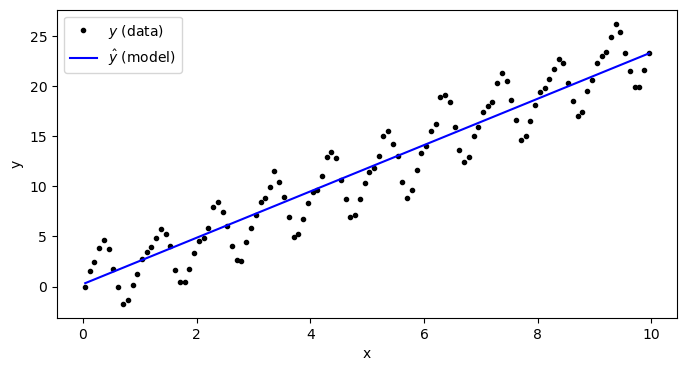

In [12]:
plt.figure(figsize=(8,4))
plt.plot(x,y,'k.',label='$y$ (data)')
plt.plot(x,y_predict,'b-',label='$\\hat{y}$ (model)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=2)
plt.show()

Clearly, this is a much better fit than before! 

One important thing to consider in the training of our model is how well the model is fitting our data. This is given by the loss function. In the class above, the losses we tallied on each model iteration so we can examine those on a curve:

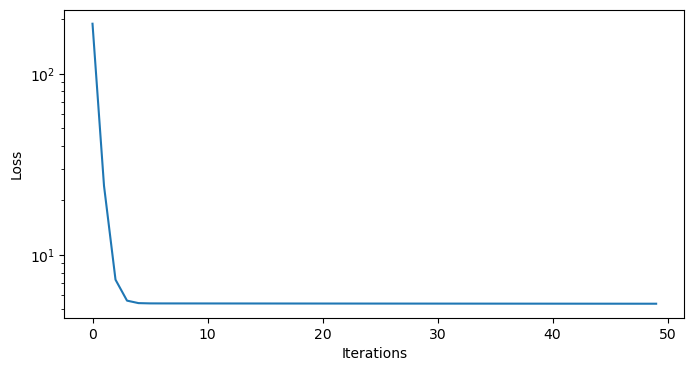

In [13]:
plt.figure(figsize=(8,4))
plt.semilogy(np.arange(50), model.losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

As we can see, the losses took a deep plunge in the first 5 iterations and started to plateau after that. A plateau in the loss function is a good indication that the model solution is converging to the best fit parameters for the data. We will be investigating lots of loss functions in this book because it is one of the key metrics for assessing a model.

**Key Takeaways**

1. The loss function gradients with respect to model parameters can be expressed in vector notation as 

$$
\frac{\partial L}{\partial \textbf{w}} = \frac{-2}{N} (\textbf{y} - \hat{\textbf{y}})^T \cdot \textbf{X}
$$

2. The iterative solution of model parameters can be built into a Python class with a series of functions that initialize and fit the model to data.

3. The model loss function provides key information on the convergence of the model parameters to the "best guess".